# Learning with the Monge gap

In [8]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [13]:
import dataclasses
from types import MappingProxyType
from typing import Any, Dict, Iterator, Literal, Mapping, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import optax
import sklearn.datasets
from flax import linen as nn

from matplotlib import pyplot as plt

from ott.geometry import costs, pointcloud
from ott.problems.nn import dataset
from ott.solvers.linear import acceleration
from ott.solvers.nn import losses, models
from ott.tools import map_estimator, sinkhorn_divergence


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


ModuleNotFoundError: No module named 'sklearn'

## Description of the method

Let $\mu, \nu$ two probability measures supported on $\mathbb{R}^d$ and $c : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ a cost function. Our goal in this tutorial is to learn an *optimal transport* (OT) map, a.k.a. a Monge map, between $\mu$ and $\nu$, that is optimal for the cost $c$:

$$
T^\star_{\mu\rightarrow\nu} \in \arg\min_{\substack{T:\mathbb{R}^d \rightarrow \mathbb{R}^d \\ T \sharp \mu = \nu}} \int c(x,T(x)) d\mu(x)
$$

We implement in this notebook the {func}`~ott.solvers.nn.losses.monge_gap` regularized approach proposed by {cite}`uscidda:23`.

In a nutshell, {cite}`uscidda:23` propose to split the task of learning a map $T$ that approximates $T^\star_{\mu\rightarrow\nu}$ by asking two things: that $T$ maps approximately $\mu$ to $\nu$ (the push-forward constraint), and that $T$ mimics as closely as possible an optimal transport map for cost $c$. To quantify that latter property, given a candidate map $T : \mathbb{R}^d \rightarrow \mathbb{R}^d$, the Monge gap of $T$, $\mathcal{M}_\mu^c(T)$ measures ``how close'' $T$ can be to the Monge map for $c$ between $\mu$ and $T\sharp \mu$. This quantity is computed as

$$
\mathcal{M}_\mu^c(T) = \int c(x,T(x)) \textrm{d}\mu(x) - W(\mu,T\sharp \mu)
$$
where the Wasserstein distance is simply the transport cost value attained by the optimal map,
$$
W(\mu,T\sharp \mu) = \min_{\substack{T:\mathbb{R}^d \rightarrow \mathbb{R}^d \\ T^\star \sharp \mu = T\sharp\mu}} \int c(x,T(x)) \textrm{d}\mu(x)
$$
Notice that the Monge gap can be equivalently rewritten as,
$$
\mathcal{M}_\mu^c(T) = \int c(x,T(x)) - c(x,T^\star_{\mu\rightarrow T\sharp\mu}\textrm{d}\mu(x),
$$
but because there exist efficient ways to compute the Wasserstein distance (that do not require computing Monge maps) we will focus on the former expression.

{cite}`uscidda:23` proves that $\mathcal{M}_\mu^c(T) = 0$ i.f.f. $T$ is optimal between $\mu$ and $T \sharp \mu$ for the cost $c$. Using a fitting loss $\Delta$ to satisfy the transport constraint $T \sharp \mu = \nu$ and introducing a regularization weight $\lambda_\mathrm{MG} > 0$, the above problem can therefore be reformulated as:

$$
T^\star \in \arg\min_{T:\mathbb{R}^d \rightarrow \mathbb{R}^d} \Delta(T\sharp \mu, \nu) + \lambda_\mathrm{MG} \mathcal{M}_\mu^c(T)
$$

We can solve this problem by introducing a parameterized family of maps $\{T_\theta\}_{\theta \in \mathbb{R}^d}$ with neural networks and using the {class}`~ott.tools.map_estimator.MapEstimator` solver.

For the squared-Euclidean cost, this method provides a simple alternative to the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solver. Actually, when we use the latter by parameterizing dual potentials $f_\theta, g_\theta$ with {class}`~ott.solvers.nn.models.MLP`s instead {class}`~ott.solvers.nn.models.ICNN`s, we can also use the Monge gap to penalize these potentials to deviate from being the gradient of a convex function. To that end, we just need to add $\mathcal{M}_\mu^2(\nabla f_\theta) + \mathcal{M}_\mu^2(\nabla g_\theta)$ to the loss function, where $\mathcal{M}_\mu^2$ is the Monge gap instantiated with the {func}`~ott.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`. This approach is not covered in this notebook.

## Generate data

We illustrate different uses of the Monge gap for various costs $c$. We generate first a few datasets.

In [1]:
@dataclasses.dataclass
class SklearnDistribution:
    """A class to define toy probability 2-dimensional distributions,
    from rotated ``moons`` and ``s_curve`` sklearn datasets.
    One can rotate the distribution by setting the ``theta_rotation``.
    """

    name: Literal["moon", "s_curve"]
    theta_rotation: float = (0.0,)
    mean: jnp.ndarray = (jnp.zeros(2),)
    noise: float = (0.01,)
    scale: float = 1.0
    batch_size: int = 1024
    init_rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0)

    def __iter__(self) -> Iterator[jnp.ndarray]:
        """Random sample generator from Gaussian mixture.

        Returns:
        A generator of samples from the Gaussian mixture.
        """
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = self.init_rng

        # define rotation matrix tp rotate samples
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=[self.batch_size, 0],
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                X, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = X[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            samples = self.mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 1024,
    valid_batch_size: int = 1024,
    rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0),
) -> Tuple[dataset.Dataset, dataset.Dataset, int]:
    """Samplers from ``SklearnDistribution``."""
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                init_rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                init_rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = dataset.Dataset(
        source_iter=iter(
            SklearnDistribution(
                init_rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                init_rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data


def plot(
    batch: Dict[str, Any],
    num_points: Optional[int] = None,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 8),
    rng: jax.random.PRNGKeyArray = jax.random.PRNGKey(0),
):
    """
    Plot samples from the source and target measures.
    If source samples mapped by the fitted map are provided in ``batch``,
    the function plots these prediction.
    """

    fig, ax = plt.subplots(figsize=figsize)
    if num_points is None:
        subsample = jnp.arange(len(batch["source"]))
    else:
        subsample = jax.random.choice(
            rng, a=len(batch["source"]), shape=(num_points,)
        )
    ax.scatter(
        batch["source"][subsample, 0],
        batch["source"][subsample, 1],
        label="source",
        c="b",
        edgecolors="k",
        s=300,
        alpha=0.8,
    )
    ax.scatter(
        batch["target"][subsample, 0],
        batch["target"][subsample, 1],
        label="target",
        c="r",
        edgecolors="k",
        marker="X",
        s=300,
        alpha=0.6,
    )
    bool_plot_pred = "mapped_source" in batch
    if "mapped_source" in batch:
        ax.scatter(
            batch["mapped_source"][subsample, 0],
            batch["mapped_source"][subsample, 1],
            label="push-forward",
            c="orange",
            edgecolors="k",
            marker="X",
            s=300,
            alpha=0.8,
        )
        z = batch["mapped_source"] - batch["source"]
        ax.quiver(
            batch["source"][subsample, 0],
            batch["source"][subsample, 1],
            z[subsample, 0],
            z[subsample, 1],
            angles="xy",
            scale_units="xy",
            scale=1.0,
            width=0.003,
            headwidth=10,
            headlength=10,
            color="dodgerblue",
            edgecolor="k",
            alpha=0.5,
        )
    if title is None:
        title = (
            r"Fitted map $\hat{T}_\theta$"
            if bool_plot_pred
            else r"Source and Target Measures"
        )
    ax.set_title(title, fontsize=30, y=1.01)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=25)
    fig.tight_layout()
    plt.show()

NameError: name 'dataclasses' is not defined

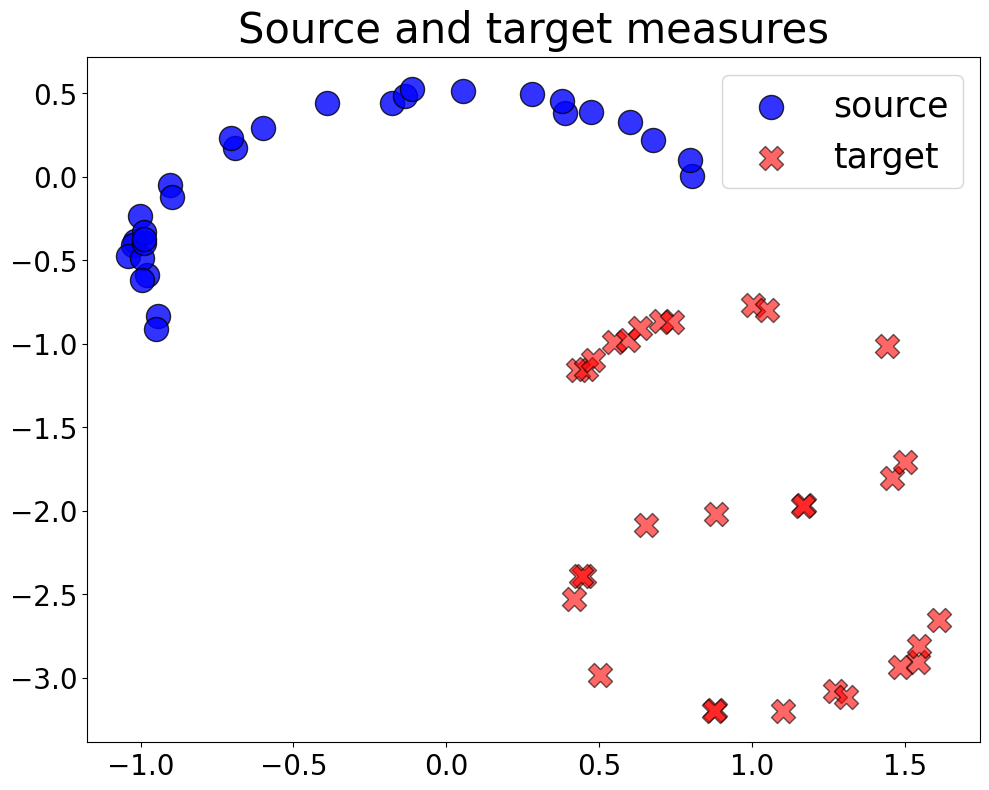

In [91]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.02,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([1.0, -2.0]),
        "theta_rotation": jnp.pi / 2,
        "noise": 0.03,
    },
)

batch = {}
batch["source"] = next(train_dataset.source_iter)
batch["target"] = next(train_dataset.target_iter)
plot(batch=batch, num_points=30)

## Learning the maps

Afterwards, we use to Monge gap to fit **(i)** an OT map for the squared-Euclidean cost $c = \ell_2^2$ and **(ii)** an OT map for the euclidean cost $c = \ell_2$. Therefore we instantiate two different Monge gaps, one for each cost. We also fit a map without Monge gap, minimizing only the fitting loss $\Delta$, to learn an arbitrary push-forward between $\mu$ and $\nu$. 

We use standard {class}`~ott.solvers.nn.models.MLP`s to parameterize the maps. For $c = \ell_2^2$, we use $\lambda_\mathrm{MG} = 1$ and for $c = \ell_2$ we use $\lambda_\mathrm{MG} = 2.5$. For all fittings, we use $\Delta = S_{\varepsilon, \ell_2^2}$, the {func}`~ott.tools.sinkhorn_divergence.sinkhorn_divergence` with the {class}`squared-Euclidean cost <ott.geometry.costs.SqEuclidean>`.

In [93]:
# The fitting loss is the same (SqEuc Sinkhorn-Divergence) for all Monge gaps.
epsilon = 1e-1
sinkhorn_kwargs = {
    "momentum": acceleration.Momentum(value=1.0, start=20),
}
fitting_loss = jax.tree_util.Partial(
    sinkhorn_divergence.sinkhorn_divergence,
    epsilon=epsilon,
    sinkhorn_kwargs=sinkhorn_kwargs,
)

In [4]:
# experimental setting
dim_data = 2
num_train_iters = 5_000
logging = True
valid_freq = 500

# define the parameterization of the neural map
model = models.MLP(dim_hidden=[128, 64, 64], is_potential=False, act_fn=nn.gelu)

optimizer = optax.adam(learning_rate=1e-2)


# we fit a map:
# - without Monge gap,
# - with squared-Euclidean Monge gap,
# - with euclidean Monge gap.
# for key, cost_fn in zip(
#     ["no_monge_gap", r"\ell_2", r"\ell_2^2"],
#     [None, costs.Euclidean(), costs.SqEuclidean()],
# ):
def train_map(cost_fn, name_gap):
    msg = (
        "without Monge gap"
        if cost_fn is None
        else f"with ${name_gap}$ Monge gap"
    )
    print(f"Fitting {msg}: in progress... ")

    # define regularizer
    regularizer_strength = 2.5 if name_gap == r"\ell_2" else 1.0
    if cost_fn is None:
        regularizer = None
    else:
        regularizer = jax.tree_util.Partial(
            losses.monge_gap_from_samples,
            cost_fn=cost_fn,
            epsilon=epsilon,
            **sinkhorn_kwargs,
        )

    # define solver
    solver = map_estimator.MapEstimator(
        dim_data=dim_data,
        fitting_loss=fitting_loss,
        regularizer=regularizer,
        model=model,
        optimizer=optimizer,
        regularizer_strength=regularizer_strength,
        num_train_iters=num_train_iters,
        logging=logging,
        valid_freq=valid_freq,
    )

    neural_state, _ = solver.train_map_estimator(
        trainloader_source=train_dataset.source_iter,
        trainloader_target=train_dataset.target_iter,
        validloader_source=valid_dataset.source_iter,
        validloader_target=valid_dataset.target_iter,
    )

    # plot the fitted map
    batch["mapped_source"] = neural_state.apply_fn(
        {"params": neural_state.params},
        batch["source"],
    )
    plot(
        batch=batch,
        num_points=30,
        title=r"Fitted map $\hat{T}_\theta$ " + msg,
    )
    print(f"Fitting {msg}: done! \n")

NameError: name 'models' is not defined

In [ ]:
train_map(None, "no_monge_gap")

As expected, the three learned maps are different. Without the Monge gap, the algorithm minimizes the fitting loss, but this results an arbitrary push-forward map that has no reason to be optimal for any cost.

In [ ]:
train_map(costs.Euclidean(), "r"\ell_2"")

When adding the Monge gap to that fitting loss, with $c = \ell_2$, we obtain map lines that form a "needle arrangement" (without crossing lines) because $c$ is a distance: this is known as the Monge Mather shortening principle (see e.g. {cite}`villani:09`). 

In [ ]:
train_map(costs.SqEuclidean(), r"\ell_2^2")

For $c = \ell_2^2$, crossings can (and do) happen: they can appear when the sum of the squared diagonals of the quadrilateral induced by 2 origin and 2 target points is lower than the sum of the squared sides.